https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

In [2]:
DATA_PATH = '../input'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

/home/nagae/.conda/envs/gpu-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [6]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [7]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [8]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [9]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [10]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [11]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [12]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [13]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [14]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [15]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [16]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [17]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [18]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43363, 73)
CPU times: user 3.13 s, sys: 79.9 ms, total: 3.21 s
Wall time: 854 ms


In [19]:
full.head()

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,10,2,1,0,32.688900,0.017257,0.012545,-0.027377,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017190,1.618523,1.017187,1.618710,1.017208,1.618706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,2,0,32.689098,0.915789,1.358745,-0.028758,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.017257,-0.520278,NaN,NaN,NaN,NaN,NaN,NaN,0.012545,1.343532,NaN,NaN,NaN,NaN,NaN,NaN,-0.027377,-0.775543,NaN,NaN,NaN,NaN,NaN,NaN,1.017187,1.618523,1.017190,1.618706,1.017208,1.618710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,2,3,0,32.690498,-0.520278,1.343532,-0.775543,-0.040426,1.024108,0.062564,1,1,0,0,0,0,0,0,0.915789,0.017257,NaN,NaN,NaN,NaN,NaN,NaN,1.358745,0.012545,NaN,NaN,NaN,NaN,NaN,NaN,-0.028758,-0.027377,NaN,NaN,NaN,NaN,NaN,NaN,1.017208,1.618706,1.017187,1.618710,1.017190,1.618523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,12,3,0,55.525200,0.825355,1.885049,0.003738,-0.025900,1.346146,0.008894,1,6,8,1,0,0,0,0,-0.908377,0.046467,1.071835,-0.961441,NaN,NaN,NaN,NaN,1.826796,-0.011743,-0.652588,-0.475004,NaN,NaN,NaN,NaN,0.018920,0.001204,-0.011133,0.008074,NaN,NaN,NaN,NaN,1.007511,1.734777,1.004933,2.050487,1.359838,2.071779,2.549623,2.280430,3.173246,1.209220,2.960154,2.047394,2.302437,1.109295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101,12,4,0,54.735901,-0.908377,1.826796,0.018920,-0.025900,1.346146,0.008894,1,6,1,8,0,0,0,0,0.825355,0.046467,-0.961441,1.071835,NaN,NaN,NaN,NaN,1.885049,-0.011743,-0.475004,-0.652588,NaN,NaN,NaN,NaN,0.003738,0.001204,0.008074,-0.011133,NaN,NaN,NaN,NaN,1.004933,1.734777,1.007511,2.071779,1.359838,2.050487,2.302437,2.047394,2.960154,1.109295,3.173246,2.280430,2.549623,1.209220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df = take_n_atoms(full, 10)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')

In [21]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((34690, 38), (8673, 38), (34690,), (8673,))

In [40]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 15,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [45]:
LGB_PARAMS_1JHN= {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 64,
    'min_child_samples': 79,
    'max_depth': 12,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [23]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.373664	valid_1's l1: 0.48981
[200]	training's l1: 0.296557	valid_1's l1: 0.446742
[300]	training's l1: 0.247452	valid_1's l1: 0.424625
[400]	training's l1: 0.210984	valid_1's l1: 0.410619
[500]	training's l1: 0.183504	valid_1's l1: 0.400631
[600]	training's l1: 0.158901	valid_1's l1: 0.393269
[700]	training's l1: 0.139522	valid_1's l1: 0.387746
[800]	training's l1: 0.123854	valid_1's l1: 0.383704
[900]	training's l1: 0.11068	valid_1's l1: 0.380712
[1000]	training's l1: 0.099639	valid_1's l1: 0.378078
[1100]	training's l1: 0.0903025	valid_1's l1: 0.376126
[1200]	training's l1: 0.0820192	valid_1's l1: 0.37463
[1300]	training's l1: 0.0746408	valid_1's l1: 0.373125
[1400]	training's l1: 0.0684193	valid_1's l1: 0.371902
[1500]	training's l1: 0.0625234	valid_1's l1: 0.370788
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0625234	valid_1's l1: 0.370788


-0.9921234999423947

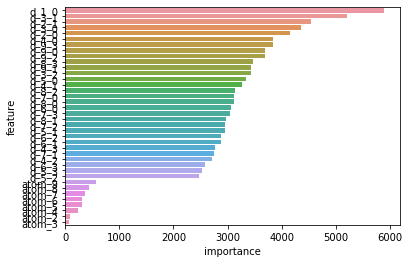

In [24]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [66]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
        
    return X_data, y_data

In [55]:
from keras.models import Sequential
from keras.layers import Dense

def make_nn(input_dim):
    model=Sequential()
    model.add(Dense(64,input_dim=input_dim,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='rmsprop',loss='mean_absolute_error',metrics=['mae'])
    return model

In [68]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    from sklearn.preprocessing import StandardScaler
    sc=StandardScaler()
    X_data=sc.fit_transform(X_data)
    X_test=sc.transform(X_test)
    
    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]
        
        #if coupling_type=='1JHN':
        #    model = LGBMRegressor(**LGB_PARAMS_1JHN, n_estimators=1500, n_jobs = -1)
        #else:
        #    model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        #model.fit(X_train, y_train, 
        #    eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        #    verbose=100, early_stopping_rounds=200)
        
        model=make_nn(X_train.shape[1])
        model.fit(X_train,y_train,epochs=50,batch_size=128,validation_data=[X_val,y_val])
        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        pred=model.predict(X_test)
        pred=pred.reshape(X_test.shape[0],)
        print(y_pred.shape)
        y_pred += pred / n_folds
        print(cv_score)
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [ ]:
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Train on 34690 samples, validate on 8673 samples
Epoch 1/50
34690/34690 [==============================] - 1s 18us/step - loss: 23.7609 - mean_absolute_error: 23.7609 - val_loss: 4.4902 - val_mean_absolute_error: 4.4902
Epoch 2/50
34690/34690 [==============================] - 0s 11us/step - loss: 2.5375 - mean_absolute_error: 2.5375 - val_loss: 1.9637 - val_mean_absolute_error: 1.9637
Epoch 3/50
34690/34690 [========

34690/34690 [==============================] - 0s 11us/step - loss: 0.8078 - mean_absolute_error: 0.8078 - val_loss: 1.2088 - val_mean_absolute_error: 1.2088
Epoch 46/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8042 - mean_absolute_error: 0.8042 - val_loss: 1.3857 - val_mean_absolute_error: 1.3857
Epoch 47/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8080 - mean_absolute_error: 0.8080 - val_loss: 1.0109 - val_mean_absolute_error: 1.0109
Epoch 48/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8017 - mean_absolute_error: 0.8017 - val_loss: 1.3016 - val_mean_absolute_error: 1.3016
Epoch 49/50
34690/34690 [==============================] - 0s 10us/step - loss: 0.7999 - mean_absolute_error: 0.7999 - val_loss: 1.5651 - val_mean_absolute_error: 1.5651
Epoch 50/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.7986 - mean_absolute_error: 0.7986 - val_loss: 1.1547 - val_mean_absolute_error:

34690/34690 [==============================] - 0s 12us/step - loss: 0.7956 - mean_absolute_error: 0.7956 - val_loss: 1.1607 - val_mean_absolute_error: 1.1607
Epoch 43/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.7917 - mean_absolute_error: 0.7917 - val_loss: 1.4984 - val_mean_absolute_error: 1.4984
Epoch 44/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.7910 - mean_absolute_error: 0.7910 - val_loss: 1.1863 - val_mean_absolute_error: 1.1863
Epoch 45/50
34690/34690 [==============================] - 0s 12us/step - loss: 0.7884 - mean_absolute_error: 0.7884 - val_loss: 0.9977 - val_mean_absolute_error: 0.9977
Epoch 46/50
34690/34690 [==============================] - 0s 12us/step - loss: 0.7802 - mean_absolute_error: 0.7802 - val_loss: 1.3543 - val_mean_absolute_error: 1.3543
Epoch 47/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.7864 - mean_absolute_error: 0.7864 - val_loss: 1.6040 - val_mean_absolute_error:

34690/34690 [==============================] - 0s 12us/step - loss: 0.8112 - mean_absolute_error: 0.8112 - val_loss: 0.9199 - val_mean_absolute_error: 0.9199
Epoch 40/50
34690/34690 [==============================] - 0s 12us/step - loss: 0.8104 - mean_absolute_error: 0.8104 - val_loss: 1.2279 - val_mean_absolute_error: 1.2279
Epoch 41/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8065 - mean_absolute_error: 0.8065 - val_loss: 1.3752 - val_mean_absolute_error: 1.3752
Epoch 42/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8049 - mean_absolute_error: 0.8049 - val_loss: 1.1116 - val_mean_absolute_error: 1.1116
Epoch 43/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.8060 - mean_absolute_error: 0.8060 - val_loss: 0.8663 - val_mean_absolute_error: 0.8663
Epoch 44/50
34690/34690 [==============================] - 0s 11us/step - loss: 0.7987 - mean_absolute_error: 0.7987 - val_loss: 1.2377 - val_mean_absolute_error:

567532/567532 [==============================] - 7s 12us/step - loss: 1.6939 - mean_absolute_error: 1.6939 - val_loss: 1.7493 - val_mean_absolute_error: 1.7493
Epoch 32/50
567532/567532 [==============================] - 7s 12us/step - loss: 1.6902 - mean_absolute_error: 1.6902 - val_loss: 1.7163 - val_mean_absolute_error: 1.7163
Epoch 33/50
567532/567532 [==============================] - 7s 11us/step - loss: 1.6874 - mean_absolute_error: 1.6874 - val_loss: 1.6844 - val_mean_absolute_error: 1.6844
Epoch 34/50
567532/567532 [==============================] - 7s 12us/step - loss: 1.6840 - mean_absolute_error: 1.6840 - val_loss: 1.6701 - val_mean_absolute_error: 1.6701
Epoch 35/50
567532/567532 [==============================] - 6s 11us/step - loss: 1.6811 - mean_absolute_error: 1.6811 - val_loss: 1.8204 - val_mean_absolute_error: 1.8204
Epoch 36/50
567532/567532 [==============================] - 7s 12us/step - loss: 1.6764 - mean_absolute_error: 1.6764 - val_loss: 1.7460 - val_mean_abs

567533/567533 [==============================] - 6s 11us/step - loss: 1.7205 - mean_absolute_error: 1.7205 - val_loss: 1.7045 - val_mean_absolute_error: 1.7045
Epoch 29/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7137 - mean_absolute_error: 1.7137 - val_loss: 1.6702 - val_mean_absolute_error: 1.6702
Epoch 30/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7080 - mean_absolute_error: 1.7080 - val_loss: 1.7156 - val_mean_absolute_error: 1.7156
Epoch 31/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7022 - mean_absolute_error: 1.7022 - val_loss: 1.6988 - val_mean_absolute_error: 1.6988
Epoch 32/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.6979 - mean_absolute_error: 1.6979 - val_loss: 1.7776 - val_mean_absolute_error: 1.7776
Epoch 33/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.6909 - mean_absolute_error: 1.6909 - val_loss: 1.6305 - val_mean_abs

567533/567533 [==============================] - 6s 11us/step - loss: 1.7252 - mean_absolute_error: 1.7252 - val_loss: 1.7770 - val_mean_absolute_error: 1.7770
Epoch 26/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7193 - mean_absolute_error: 1.7193 - val_loss: 1.6783 - val_mean_absolute_error: 1.6783
Epoch 27/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7139 - mean_absolute_error: 1.7139 - val_loss: 1.6723 - val_mean_absolute_error: 1.6723
Epoch 28/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7090 - mean_absolute_error: 1.7090 - val_loss: 1.6404 - val_mean_absolute_error: 1.6404
Epoch 29/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.7038 - mean_absolute_error: 1.7038 - val_loss: 1.8118 - val_mean_absolute_error: 1.8118
Epoch 30/50
567533/567533 [==============================] - 6s 11us/step - loss: 1.6991 - mean_absolute_error: 1.6991 - val_loss: 1.7413 - val_mean_abs

302428/302428 [==============================] - 3s 11us/step - loss: 0.3878 - mean_absolute_error: 0.3878 - val_loss: 0.3818 - val_mean_absolute_error: 0.3818
Epoch 18/50
302428/302428 [==============================] - 3s 11us/step - loss: 0.3845 - mean_absolute_error: 0.3845 - val_loss: 0.3805 - val_mean_absolute_error: 0.3805
Epoch 19/50
302428/302428 [==============================] - 3s 11us/step - loss: 0.3819 - mean_absolute_error: 0.3819 - val_loss: 0.3985 - val_mean_absolute_error: 0.3985
Epoch 20/50
302428/302428 [==============================] - 3s 11us/step - loss: 0.3786 - mean_absolute_error: 0.3786 - val_loss: 0.3941 - val_mean_absolute_error: 0.3941
Epoch 21/50
302428/302428 [==============================] - 3s 11us/step - loss: 0.3757 - mean_absolute_error: 0.3757 - val_loss: 0.3788 - val_mean_absolute_error: 0.3788
Epoch 22/50
302428/302428 [==============================] - 3s 11us/step - loss: 0.3732 - mean_absolute_error: 0.3732 - val_loss: 0.3746 - val_mean_abs

302429/302429 [==============================] - 3s 11us/step - loss: 0.4114 - mean_absolute_error: 0.4114 - val_loss: 0.4201 - val_mean_absolute_error: 0.4201
Epoch 15/50
302429/302429 [==============================] - 3s 11us/step - loss: 0.4063 - mean_absolute_error: 0.4063 - val_loss: 0.3975 - val_mean_absolute_error: 0.3975
Epoch 16/50
302429/302429 [==============================] - 3s 11us/step - loss: 0.4014 - mean_absolute_error: 0.4014 - val_loss: 0.4105 - val_mean_absolute_error: 0.4105
Epoch 17/50
302429/302429 [==============================] - 4s 12us/step - loss: 0.3969 - mean_absolute_error: 0.3969 - val_loss: 0.3948 - val_mean_absolute_error: 0.3948
Epoch 18/50
302429/302429 [==============================] - 4s 12us/step - loss: 0.3936 - mean_absolute_error: 0.3936 - val_loss: 0.4017 - val_mean_absolute_error: 0.4017
Epoch 19/50
302429/302429 [==============================] - 3s 11us/step - loss: 0.3896 - mean_absolute_error: 0.3896 - val_loss: 0.3975 - val_mean_abs

In [48]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHN,-0.989828
1,1JHC,-0.259521
2,2JHH,-1.739042
3,2JHN,-1.957707
4,2JHC,-1.182418
5,3JHH,-1.743725
6,3JHC,-1.093818
7,3JHN,-2.196844


In [49]:
np.mean(list(cv_scores.values()))

-1.3953628002312313

In [50]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [51]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,24.443258
4658148,142.937302
4658149,9.953008
4658150,142.937302
4658151,24.443258
4658152,93.242844
4658153,2.555109
4658154,-7.562157
4658155,-9.632586


In [52]:
submission.to_csv(f'{SUBMISSIONS_PATH}/sub_lightgbm_two_params.csv')

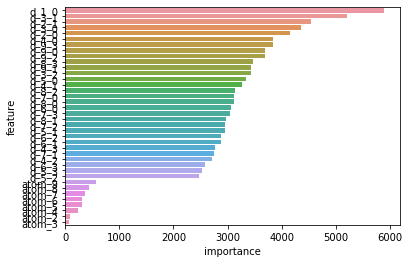

In [53]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));